# CallMeMaybe: Identificación de operadores ineficaces
#### **Autor:** *I.S.C. Dan Levi Menchaca* > *danlevimb@gmail.com*
30/09/2025

## Sin tanto rollo:
- **Problema:** Necesitamos identificar a los **operadores menos eficaces** y conocer el comportamiento de los tiempos de espera de las llamadas.
- **¿Qué hicimos?:** EDA, métricas por **día–operador**, reglas por **cliente** (percentiles), pruebas estadísticas (Mann-Whitney, Kruskal, Spearman) y un **dashboard** en Tableau.
- **¿Qué sigue?:** Ajustar procedimientos de supervision / coaching a operadores identificados, ajustes de enrutamiento / turnos y adopción del dashboard con alertas.

## 1. Datos y supuestos.
- Fuentes: `telecom_dataset_us.csv`, `telecom_clients_us.csv`.
- Unión: `user_id`. Grano: **día–operador**.
- Definiciones: `wait_time = total_call_duration - call_duration` (>= 0), entrante asignada = contestada + perdida **post**.
- Ventana de análisis: últimas **4 semanas** (período estadísticamente estable).

## 2. Construcción de métricas.
Resumen de cómo se generan las métricas diarias por operador (entrantes, perdidas post, espera, OUT) y su agregación por cliente/operador.

## 3. Análisis Exploratorio de Datos (EDA).
Incluye histogramas de duración (P50/P80), tops de `missed_rate_post` y dispersión `missed` vs `avg_wait`.

## 4. Reglas para operadores ineficaces.
Se considera y marca **ineficaz** a los operadores que, con volumen suficiente, cumplen:
- `missed_rate_post` ≥ P80 **y** `avg_wait_in_ans` ≥ P80; **o**
- `missed_rate_post` ≥ P80 **y** OUT bajo (≤ P20) cuando `expected_outbound`.
Umbrales por **cliente** para ser justos con el contexto.

In [99]:
# Importar librerías y carga de archivos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from matplotlib.ticker import PercentFormatter

# Leer datos
# calls_path = 'C:/Git/vehicles_env/datasets/telecom_dataset_us.csv'
# clients_path = 'C:/Git/vehicles_env/datasets/telecom_clients_us.csv'

calls_path = 'telecom_dataset_us.csv'
clients_path = 'telecom_clients_us.csv'

calls = pd.read_csv(calls_path, parse_dates=['date']) 
clients = pd.read_csv(clients_path, parse_dates=['date_start'])

In [100]:
# Normalizar tipos y valores
calls['direction'] = calls['direction'].str.strip().str.lower()

# Poner las columas al tipo de dato correspondiente
calls['internal'] = calls['internal'].astype(bool)
calls['is_missed_call'] = calls['is_missed_call'].astype(bool)        
calls['operator_id'] = pd.to_numeric(calls['operator_id'], errors='coerce')

In [101]:
# Integrar columnas derivadas
calls['wait_time'] = calls['total_call_duration'] - calls['call_duration']
calls['has_operator'] = calls['operator_id'].notna()
calls['is_inbound']   = calls['direction'].eq('in')
calls['is_outbound']  = calls['direction'].eq('out')

# Distinguir si las llamadas perdidas fueron antes o despues de asignarles operador
calls['miss_stage'] = np.where(
    calls['is_inbound'] & calls['is_missed_call'] & ~calls['has_operator'], 'pre', # Si la llamada es interna, perdida y NO tiene operador es PRE
    np.where(calls['is_inbound'] & calls['is_missed_call'] & calls['has_operator'], 'post', None)) # Si la llamada es externa, perdida y SI tiene operador es POST

# Se define una ventana de tiempo de análisis de 28 días. (Customizable al set completo de datos)
window_start = calls['date'].max() - pd.Timedelta(days=27) 
calls_win = calls[(calls['date'] >= window_start) & (calls['date'] <= calls['date'].max())].copy()
print('Ventana de tiempo para análisis: Del ', window_start.date(), 'hasta el', calls['date'].max())

Ventana de tiempo para análisis: Del  2019-11-01 hasta el 2019-11-28 00:00:00+03:00


In [102]:
# Filtros auxiliares
in_ans = (calls_win["is_inbound"] & ~calls_win["is_missed_call"] & calls_win["has_operator"])
in_miss_post = (calls_win["is_inbound"] & calls_win["is_missed_call"] & calls_win["has_operator"])
in_miss_pre  = (calls_win["is_inbound"] & calls_win["is_missed_call"] & ~calls_win["has_operator"])
out_ext = (calls_win["is_outbound"] & (calls_win["internal"] == False))  # salientes externas

# Columnas derivadas (0 donde no aplica)
calls_win["in_ans_calls"]            = np.where(in_ans,       calls_win["calls_count"], 0)
calls_win["in_ans_wait_sum"]         = np.where(in_ans,       calls_win["wait_time"], 0.0)
calls_win["in_miss_post_calls"]      = np.where(in_miss_post, calls_win["calls_count"], 0)
calls_win["in_miss_post_wait_sum"]   = np.where(in_miss_post, calls_win["total_call_duration"], 0.0)
calls_win["in_miss_pre_calls"]       = np.where(in_miss_pre,  calls_win["calls_count"], 0)
calls_win["in_miss_pre_wait_sum"]    = np.where(in_miss_pre,  calls_win["total_call_duration"], 0.0)
calls_win["out_ext_calls"]           = np.where(out_ext,      calls_win["calls_count"], 0)
calls_win["any_activity"]            = (calls_win["calls_count"] > 0).astype(int)

grp_keys = ["user_id","operator_id","date"]

daily = (
    calls_win.groupby(grp_keys, as_index=False)
      .agg(
          in_ans_calls=("in_ans_calls","sum"),
          in_ans_wait_sum=("in_ans_wait_sum","sum"),
          in_miss_post_calls=("in_miss_post_calls","sum"),
          in_miss_post_wait_sum=("in_miss_post_wait_sum","sum"),
          in_miss_pre_calls=("in_miss_pre_calls","sum"),
          in_miss_pre_wait_sum=("in_miss_pre_wait_sum","sum"),
          out_ext_calls=("out_ext_calls","sum"),
          any_activity=("any_activity","max")  # si hubo al menos algo ese día
      ))

# Derivados diarios
daily["in_assigned_total"] = daily["in_ans_calls"] + daily["in_miss_post_calls"]
daily["missed_rate_post_day"] = np.where(
    daily["in_assigned_total"] > 0,
    daily["in_miss_post_calls"] / daily["in_assigned_total"],
    np.nan)

daily["avg_wait_in_ans_day"] = np.where(
    daily["in_ans_calls"] > 0,
    daily["in_ans_wait_sum"] / daily["in_ans_calls"],
    np.nan)

In [103]:
# Cálculo de métricas DIARIAS por operador 

# Determinar los días en que hubo actividad de los operadores
op_days = (daily.groupby(["user_id","operator_id"], as_index=False).agg(active_days=("any_activity", "sum")))

# Agrupar métricas
op_agg = (
    daily.groupby(["user_id","operator_id"], as_index=False)
         .agg(
             in_ans_calls=("in_ans_calls","sum"), # Total de entrantes contestadas por ese operador 
             in_miss_post_calls=("in_miss_post_calls","sum"), # Total de entrantes perdidas post-asignación
             in_ans_wait_sum=("in_ans_wait_sum","sum"), # Suma del tiempo de espera de las contestadas asignadas a ese operador.
             in_miss_post_wait_sum=("in_miss_post_wait_sum","sum"), # Suma de tiempo de espera en perdidas post-asignación
             out_ext_calls=("out_ext_calls","sum"), # Cantidad total de llamadas salientes
             avg_wait_in_ans=("avg_wait_in_ans_day","mean"), # Tiempo promedio que espera en llamadas entrantes contestadas
             missed_rate_post=("missed_rate_post_day","mean") # Tasa de llamadas perdidas post-asignación (provisional)
         ).merge(op_days, on=["user_id","operator_id"], how="left")) # Añade el # de días activos al resumen (provisional)

# Total de llamadas entrantes asignadas (contestadas y (perdidas-asignadas))
op_agg["in_assigned_total"] = op_agg["in_ans_calls"] + op_agg["in_miss_post_calls"]

# Calcular nuevamente el tiempo promedio de espera de llamadas entrantes contestadas
op_agg["avg_wait_in_ans"] = np.where(
    op_agg["in_ans_calls"] > 0,
    op_agg["in_ans_wait_sum"] / op_agg["in_ans_calls"],
    np.nan)

# Calcular nuevamente la tasa de llamadas perdidas después de la asignación. (Ya con los datos completos)
op_agg["missed_rate_post"] = np.where(
    op_agg["in_assigned_total"] > 0,
    op_agg["in_miss_post_calls"] / op_agg["in_assigned_total"],
    np.nan)

# Marcar los días en los que el operador tuvo actividad (llamadas salientes)
out_days = (daily.assign(has_out = daily["out_ext_calls"] > 0)
         .groupby(["user_id","operator_id"], as_index=False)
         .agg(out_days=("has_out","sum"))) 

# Unir los resultados agrupados con los diarios 
op_agg = op_agg.merge(out_days, on=["user_id","operator_id"], how="left")
op_agg["out_share_days"] = np.where(op_agg["active_days"]>0, op_agg["out_days"]/op_agg["active_days"], np.nan) # Proporción de días activos con llamadas salientes
op_agg["out_avg_daily"]  = np.where(op_agg["active_days"]>0, op_agg["out_ext_calls"]/op_agg["active_days"], np.nan) # Promedio diario de llamadas salientes.

# Mediana diaria de OUT sobre días activos: une daily OUT con días activos
daily_out = daily[["user_id","operator_id","date","out_ext_calls","any_activity"]].copy()

daily_out["any_activity"] = daily_out["any_activity"].astype(bool)

# Mediana diaria de OUT sobre días activos: une daily OUT con días activos
daily_out = daily[["user_id","operator_id","date","out_ext_calls","any_activity"]].copy()

daily_out["any_activity"] = daily_out["any_activity"].astype(bool)

# Si hubo actividad pero 'out_ext_calls' es nan, se considera 0 para ese día
daily_out.loc[daily_out["any_activity"] & daily_out["out_ext_calls"].isna(), "out_ext_calls"] = 0

# Calcular el desempeño diario de cada operador utilizando la mediana, 
# ya que puede haber días con picos por campañas o comportamientos atípicos.
op_median_out = (daily_out[daily_out["any_activity"]]
                 .groupby(["user_id","operator_id"], as_index=False)
                 .agg(out_median_daily=("out_ext_calls","median")))

# Agregar los datos a las métricas por operdor.
op_agg = op_agg.merge(op_median_out, on=["user_id","operator_id"], how="left")

In [104]:
# Considerar registros válidos aquellos que tengan actividad saliente.
op_agg["expected_outbound"] = (op_agg["out_share_days"] >= 0.30) | (op_agg["out_avg_daily"] >= 3)

def add_client_percentile_flags(df):
    # Función para el cálculo de percentiles por cliente para normalizar el contexto
    res = []
    for uid, g in df.groupby("user_id", dropna=False):
        # P80 de missed_rate y wait; P20 de out_median_daily
        p80_miss = np.nanpercentile(g["missed_rate_post"], 80) if g["missed_rate_post"].notna().any() else np.nan # Tasa de pérdidas post-asignación
        p80_wait = np.nanpercentile(g["avg_wait_in_ans"], 80) if g["avg_wait_in_ans"].notna().any() else np.nan # Espera promedio de entrantes contestadas
        p20_out  = np.nanpercentile(g["out_median_daily"], 20) if g["out_median_daily"].notna().any() else np.nan # mediana diaria de llamadas salientes

        gg = g.copy()
        # El operador está en el peor 20% de perdidas post-asignación de su cliente
        gg["flag_miss_high"] = gg["missed_rate_post"] >= p80_miss if pd.notna(p80_miss) else False
        
        # El operador está en el peor 20% de espera post-asignación de su cliente
        gg["flag_wait_high"] = gg["avg_wait_in_ans"] >= p80_wait if pd.notna(p80_wait) else False
        
        # Solo aplica si expected_outbound es TRUE
        # Se compara su mediana diaria de OUT contrael P20 de su cliente. 
        gg["flag_out_low"]   = np.where(gg["expected_outbound"], gg["out_median_daily"] <= p20_out, False)
        res.append(gg)
    return pd.concat(res, ignore_index=True)

# Llamar la función
op_flags = add_client_percentile_flags(op_agg)

# Etiquetar registros con suficiente robustez para ser considerados
op_flags["enough_volume"] = (
    (op_flags["in_assigned_total"] >= 20) &   # entrantes asignadas (respondidas + perdidas post) suficientes
    (op_flags["in_ans_calls"] >= 10) &        # suficientes contestadas para un promedio de espera estable
    (op_flags["active_days"] >= 7))            # al menos una semana de días observados

# Marcar al operador como ineficaz si:
# 1.- Cumple con la condición anterior
# 2.- Llamadas perdidas alto y tiempo de espera alto
# 3.- Llamadas perdidas alto y llamadas salientes bajo
op_flags["ineffective"] = op_flags["enough_volume"] & (
    (op_flags["flag_miss_high"] & op_flags["flag_wait_high"]) |
    (op_flags["flag_miss_high"] & op_flags["flag_out_low"]))

# Definir columnas para el reporte.
cols_show = [
    "user_id","operator_id","active_days","in_assigned_total","in_ans_calls","in_miss_post_calls",
    "missed_rate_post","avg_wait_in_ans",
    "out_ext_calls","out_median_daily","out_share_days","out_avg_daily","expected_outbound",
    "flag_miss_high","flag_wait_high","flag_out_low","enough_volume","ineffective"]

ineff_table = op_flags[cols_show].sort_values(["user_id","ineffective","missed_rate_post","avg_wait_in_ans"], ascending=[True, False, False, False])

### 4.1 Métricas individuales - Operadores ineficaces (preview)
Resultados en: *s14_operadores_ineficaces_metrics.csv*

In [105]:
ineff_table.head()

,user_id,operator_id,active_days,in_assigned_total,in_ans_calls,in_miss_post_calls,missed_rate_post,avg_wait_in_ans,out_ext_calls,out_median_daily,out_share_days,out_avg_daily,expected_outbound,flag_miss_high,flag_wait_high,flag_out_low,enough_volume,ineffective
0,166377,880022.0,12,7,7,0,0.0,13.428571,36,0.5,0.5,3.000000,True,True,True,True,False,False
1,166377,880026.0,19,5,5,0,0.0,8.400000,680,38.0,1.0,35.789474,True,True,False,False,False,False
2,166377,880028.0,19,29,29,0,0.0,5.931034,660,29.0,1.0,34.736842,True,True,False,False,True,False
3,166377,881278.0,2,0,0,0,NaN,NaN,5,2.5,1.0,2.500000,True,False,False,False,False,False
4,166391,882476.0,1,1,1,0,0.0,64.000000,0,0.0,0.0,0.000000,False,True,True,False,False,False


### 4.2 Métricas de equipo (preview)

 El objetivo es medir que ocurre antes de que una llamada entrante sea asignada.
 Esto es comportamiento general del call center.
 Mide:
   - Carga de la lista de espera: ¿Cuántas llamadas se van antes de ser asignadas?
   - Experiencia del cliente en lista de espera: ¿Cuánto esperan en promedio quienes abandonan?

Resultados en: *s14_queue_context_por_cliente.csv*

In [106]:
# Agrupar llamadas por cliente y día
queue_daily = (
    calls_win[calls_win["miss_stage"]=="pre"] # Filtra las llamadas que no fueron asignadas a un operador.
    .groupby(["user_id","date"], as_index=False)
    .agg(
        pre_missed_calls=("calls_count","sum"),
        pre_wait_sum=("total_call_duration","sum")))

# Tiempo de espera promedio de un cliente antes de ser asignado a un operador antes de abandonar.
queue_daily["pre_avg_wait"] = np.where(queue_daily["pre_missed_calls"]>0, queue_daily["pre_wait_sum"]/queue_daily["pre_missed_calls"], np.nan)

# Resumen a nivel cliente
queue_summary = queue_daily.groupby("user_id", as_index=False).agg(
    pre_missed_calls=("pre_missed_calls","sum"),
    pre_avg_wait=("pre_avg_wait","mean"))

print(queue_summary.head())

   user_id  pre_missed_calls  pre_avg_wait
0   166377                17     14.250000
1   166391                 2      4.000000
2   166392                31      7.022222
3   166405              1392     15.611976
4   166406                21     26.983333


# 5. Visuales.

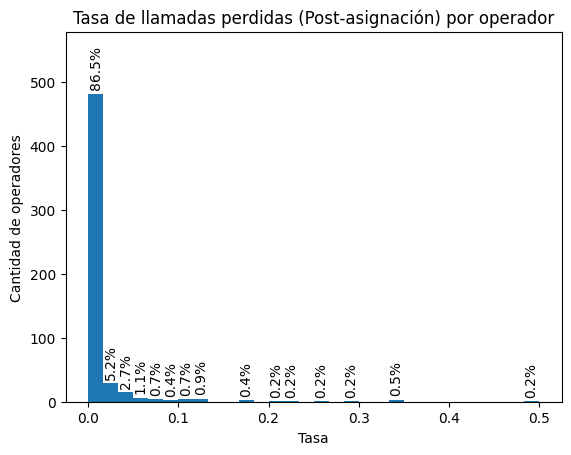

In [107]:
# G1.- Tasa de llamadas perdidas (Post-asignación) por operador
x = op_flags["missed_rate_post"].dropna()

fig, ax = plt.subplots()
n, bins, patches = ax.hist(x, bins=30)

ax.margins(y=0.20)
plt.title("Tasa de llamadas perdidas (Post-asignación) por operador")
plt.xlabel("Tasa")
plt.ylabel("Cantidad de operadores")

total = n.sum()
for rect, count in zip(patches, n):
    if count > 0:
        pct = 100*count/total
        ax.annotate(f"{pct:.1f}%",
                    (rect.get_x()+rect.get_width()/2, rect.get_height()),
                    xytext=(0, 3), textcoords="offset points",
                    ha="center", va="bottom", rotation=90)
plt.show()

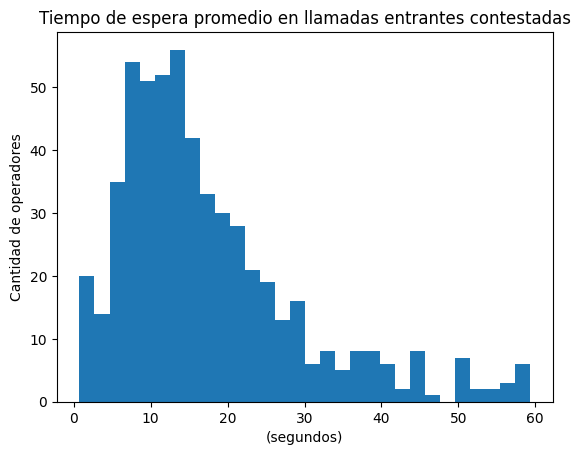

In [108]:
# G2.- Tiempo de espera promedio en llamadas entrantes contestadas 
y_raw = op_flags["avg_wait_in_ans"].dropna()

# Recortar al Percentil 99 para mejor lectura de la gráfica.
upper = np.nanpercentile(y_raw, 99) if len(y_raw) else np.nan
y = y_raw.clip(upper=upper) if np.isfinite(upper) else y_raw

plt.figure()
plt.hist(y, bins=30)
plt.title("Tiempo de espera promedio en llamadas entrantes contestadas")
plt.xlabel("(segundos)")
plt.ylabel("Cantidad de operadores")
plt.show()

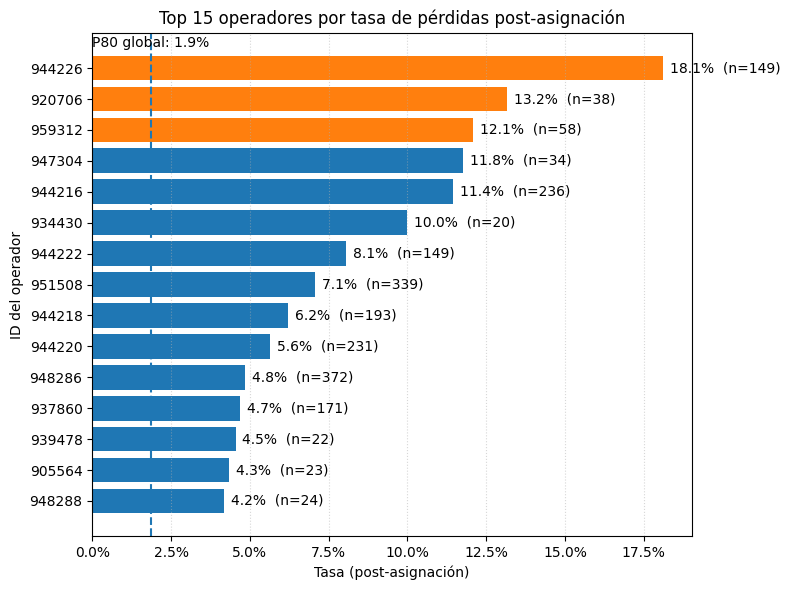

In [109]:
# G3.- Top 15 operadores por tasa de pérdidas post-asignación

base = op_flags[op_flags["enough_volume"]].copy()
top = base.sort_values("missed_rate_post", ascending=False).head(15).copy()
top["op_label"] = top["operator_id"].astype("Int64").astype(str)

p80 = np.nanpercentile(base["missed_rate_post"].dropna(), 80) # Umbral de referencia (P80 global)
colors = ["C1" if i < 3 else "C0" for i in range(len(top))] # Resaltar top 3

fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.barh(top["op_label"], top["missed_rate_post"], color=colors)

ax.invert_yaxis()
ax.xaxis.set_major_formatter(PercentFormatter(xmax=1.0))

# Línea de referencia P80
ax.axvline(p80, linestyle="--")
ax.text(p80, -0.6, f"P80 global: {p80:.1%}", ha="center", va="bottom")

# Etiquetas al final de cada barra (porcentaje + volumen n)
for bar, rate, n_assigned in zip(bars, top["missed_rate_post"], top["in_assigned_total"]):
    ax.annotate(f"{rate:.1%}  (n={int(n_assigned)})",
                xy=(rate, bar.get_y() + bar.get_height()/2),
                xytext=(5, 0), textcoords="offset points",
                va="center", ha="left")

ax.xaxis.grid(True, linestyle=":", alpha=0.5)
ax.margins(x=0.05)
ax.set_title("Top 15 operadores por tasa de pérdidas post-asignación")
ax.set_xlabel("Tasa (post-asignación)")
ax.set_ylabel("ID del operador")
plt.tight_layout()
plt.show()

In [110]:
# H1.- ¿La espera en llamadas entrantes contestadas difiere entre internas vs externas?

# Base: llamadas entrantes contestadas y asignadas
mask_ans = (calls_win["is_inbound"] & ~calls_win["is_missed_call"] & calls_win["has_operator"])

df_wait = calls_win.loc[mask_ans, ["internal","wait_time","calls_count"]].copy()

# Promedio de espera por llamada en cada fila agregada
df_wait["mean_wait_per_call"] = df_wait["wait_time"] / df_wait["calls_count"]
a = df_wait.loc[df_wait["internal"]==True,  "mean_wait_per_call"].dropna()
b = df_wait.loc[df_wait["internal"]==False, "mean_wait_per_call"].dropna()

u_stat, p_val = st.mannwhitneyu(a, b, alternative="two-sided")

def cliffs_delta(x, y):
    x = x.values if isinstance(x, pd.Series) else np.asarray(x)
    y = y.values if isinstance(y, pd.Series) else np.asarray(y)
    import itertools
    gt = sum(ix > iy for ix, iy in itertools.product(x, y))
    lt = sum(ix < iy for ix, iy in itertools.product(x, y))
    n1, n2 = len(x), len(y)
    return (gt - lt) / (n1 * n2)

delta = cliffs_delta(a, b)

## 6. Hipótesis analizadas.
#### H1 - ¿La espera en llamadas entrantes contestadas difiere entre internas vs externas?

- Aplicamos la prueba U Mann-Whitney sobre la espera media por llamada en entrantes contestadas, comparando internas vs. externas. 
- El resultado fue p = 3.408e-06, por lo que **rechazamos H0**: existe una diferencia estadísticamente significativa entre ambos tipos de llamada. El tamaño del efecto Cliff’s fue −0.185, de magnitud pequeña; el signo negativo indica que las internas tienden a menor espera que las externas.
- Implicación: La experiencia de clientes externos presenta esperas relativamente más altas; conviene revisar enrutamiento y priorización para llamadas externas.
- **En pocas palabas: Existen diferencias en la espera; externas esperan más que las internas.**

In [111]:
print(f"Mann-Whitney U p={p_val:.4g}")
print(f"Cliff's delta={delta:.3f}  (≈0.147 pequeño, ≈0.33 mediano, ≈0.474 grande)")

# H2.- ¿El plan tarifario del cliente se relaciona con la tasa de llamadas perdidas post-asignación?

# Une plan tarifario al nivel operador
op_tp = op_flags.merge(clients[["user_id","tariff_plan"]], on="user_id", how="left")

# Filtra operadores con volumen suficiente y tasa no nula
gbase = op_tp[op_tp["enough_volume"] & op_tp["missed_rate_post"].notna()].copy()

# Prepara grupos por plan
groups = [g["missed_rate_post"].values for _, g in gbase.groupby("tariff_plan") if len(g)>5]

H, p = st.kruskal(*groups)
k = len(groups)
n = sum(len(g) for g in groups)
eps2 = (H - k + 1) / (n - k) if (n - k) > 0 else np.nan

Mann-Whitney U p=3.408e-06
Cliff's delta=-0.185  (≈0.147 pequeño, ≈0.33 mediano, ≈0.474 grande)


#### H2 - ¿El plan tarifario del cliente se relaciona con la tasa de llamadas perdidas post-asignación?:

- Se evaluó si la tasa de pérdidas post-asignación difiere entre planes tarifarios. Con H = 1.376, p = 0.5026, **no rechazamos H0**: no hay evidencia de diferencias entre planes. El epsilon-cuadrado fue ≈ −0.003 (interpretado como ≈ 0), es decir, efecto nulo.
- Implicación: la variación en la tasa de pérdidas post-asignación no se explica por el plan tarifario; habrá que enfocar acciones en factores operativos (enrutamiento, horarios, coaching a operadores) más que en la tarifa.
- **En pocas palabras: Sin diferencias por plan tarifario en pérdidas post-asignación (efecto nulo).**

In [112]:
print(f"Kruskal-Wallis: H={H:.3f}, p={p:.4g}, epsilon^2={eps2:.3f}")

# H3.- ¿Existe relación entre la tasa de perdidas post-asignación y el ambiente pre-asignación?

inbound_daily = (calls_win[calls_win["is_inbound"]]
    .groupby(["user_id","date"], as_index=False)
    .agg(inbound_calls=("calls_count","sum")))

queue_daily = (calls_win[calls_win["miss_stage"]=="pre"]
    .groupby(["user_id","date"], as_index=False)
    .agg(pre_missed_calls=("calls_count","sum"),
         pre_wait_sum=("total_call_duration","sum")))

queue_daily2 = inbound_daily.merge(queue_daily, on=["user_id","date"], how="left")
queue_daily2["pre_missed_calls"] = queue_daily2["pre_missed_calls"].fillna(0)

queue_summary2 = queue_daily2.groupby("user_id", as_index=False).agg(
    inbound_calls=("inbound_calls","sum"),
    pre_missed_calls=("pre_missed_calls","sum"),
    pre_wait_sum=("pre_wait_sum","sum"))

queue_summary2["pre_avg_wait_weighted"] = np.where(
    queue_summary2["pre_missed_calls"]>0,
    queue_summary2["pre_wait_sum"]/queue_summary2["pre_missed_calls"],
    np.nan)

queue_summary2["pre_abandon_rate"] = np.where(
    queue_summary2["inbound_calls"]>0,
    queue_summary2["pre_missed_calls"]/queue_summary2["inbound_calls"],
    np.nan)

client_post = (
    op_flags[op_flags["missed_rate_post"].notna()]
    .groupby("user_id", as_index=False)
    .agg(client_missed_post_mean=("missed_rate_post","mean")))

corr_df = queue_summary2.merge(client_post, on="user_id", how="inner")

rho, p = st.spearmanr(corr_df["pre_abandon_rate"], corr_df["client_missed_post_mean"], nan_policy="omit")

Kruskal-Wallis: H=1.376, p=0.5026, epsilon^2=-0.003


#### H3 - ¿Existe relación entre la tasa de perdidas post-asignación y el ambiente pre-asignación?

Se realiza la correlación entre la tasa de abandono en espera y la tasa media de pérdidas post-asignación por cliente. 
- El valor El resultado fue rho = −0.169, p = 0.01013: existe una asociación negativa significativa, pero de magnitud pequeña.
- Implicación: A nivel cliente, **un mayor abandono en cola no se asocia con mayores pérdidas post-asignación**; por lo que en términos prácticos, conviene tratar lista de espera y desempeño post-asignación como frentes operativos distintos, evitando extraer conclusiones causales sin un análisis adicional (p. ej., por franjas horarias, mezcla de tráfico, reglas de routing).
- **Correlación negativa y pequeña entre abandono en espera y pérdidas post.**

In [113]:
print(f"Spearman rho={rho:.3f}, p={p:.4g}")

Spearman rho=-0.169, p=0.01013


# 7. Recomendaciones.
- Short-fix.- Coaching a marcados, ajustes de routing en picos.
- Mid-fix.- Rebalanceo de turnos, QA scriptado.
- Long-fix.- KPI y alertas en Tableau; playbook de supervisión.

# 8. Fuentes documentales.
1. **SciPy – `scipy.stats.mannwhitneyu`**.- Prueba no paramétrica para comparar dos muestras independientes (diferencia de localización/rangos); la utilizamos para contrastar si la espera en llamadas entrantes (internas vs externas) difiere de forma significativa.

2. **SciPy – `scipy.stats.kruskal`**.- Prueba no paramétrica utilizada para comparar **k** grupos con tamaños distintos; la utilizamos para ver si la tasa de pérdidas post-asignación cambia por plan tarifario.

3. **SciPy – `scipy.stats.spearmanr`**.- Sirve para conocer la correlación de Spearman (ρ) para relaciones monótonas sin suponer normalidad;la utilizamos para conocer la relación entre tasa de abandono en espera (pre) y pérdidas post-asignación a nivel cliente.

4. **NumPy – `numpy.nanpercentile`**.- Librería utilizada para calcular percentiles ignorando NaN; la utilizamos para definir umbrales por cliente (P80 para perdidas/en-espera, P20 para llamadas salientes) y generar métricas justas por contexto.

5. **Cliff’s delta**.- Sirve para entender y reportar el tamaño de efecto no paramétrico para comparaciones de dos grupos; la utilizamos para cuantificar la magnitud práctica al investigar si la espera en llamadas entrantes contestadas difiere entre internas vs externas.

6. **Epsilon squared**.- Se utiliza para calcular el epsilon cuadrado para Kruskal–Wallis como medida de tamaño de efecto; se utilizó para reportar la magnitud entre los grupos al investigar si el plan tarifario del cliente se asocia con la tasa de llamadas perdidas post-asignación.

7. **Genesys – Definición de ASA (Average Speed of Answer)**.- Documentación operativa de contact centers; se utilizó para definir el tiempo de espera hasta que recibe respuesta (ASA) y distinguirla de otras esperas y separar correctamente la espera pre-asignación (cola/equipo) de la espera post-asignación (operador) en nuestras métricas.

9. **Investopedia – Abandon Rate (definición y fórmula)**.- Definición de la tasa de abandono en call centers (abandoned / inbound) y su relación con tiempos de espera; se utilizó para fundamentar la métrica de abandono en espera usada como contexto de equipo (no para culpar a individuos).